In [2]:
# Prerequisets
!pip install pynetlogo
!pip install JPype1

     |████████████████████████████████| 48 kB 182 kB/s 
  Created wheel for pynetlogo: filename=pyNetLogo-0.4.1-py3-none-any.whl size=64516 sha256=bf8a40c5e8446cbca9adf286f1779b182bc7476ef5778e9660547ac4000fd1dc
  Stored in directory: /Users/ricoherzog/Library/Caches/pip/wheels/73/a0/47/93a2adf66bc7381ec21a1be6be2f774a49e4a5ee7a9ef21e54
Successfully built pynetlogo


In [21]:
# import all necessary python libraries and the pyNetLogo library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')
import pyNetLogo

from SALib.sample import latin
from SALib.analyze import sobol
from SALib.sample import saltelli

In [10]:
# set up the model
netlogo = pyNetLogo.NetLogoLink(gui=False) #Mac users should set this to False
netlogo.load_model('Model.nlogo')

# Setup Experiments
Specify the number of samples and the number of repetitions for each sample below.

In [15]:
# Parameters
no_samples = 20
no_repetitions = 100

### Experiment Sampling
Perform Latin Hypercube Sampling from all possible levers to ensure an evenly distributed sample of the lever space.

In [22]:
problem = {
  'num_vars': 7,
  'names': ['random-seed'
           'administrative-network-meetings',
           'total-project-proposal-frequency',
           'informal-meetings-frequency',
           'green-energy-openness-change',
           'political-variety-change',
           'max-project-capacity',
           'random-intial-trust'],
  'bounds': [[0, 100],
            [0, 25],
            [0, 25],
            [0, 25],
            [-5,5],
            [-5,5],
            [0, 25],
            [0, 1]]
}

n = 50
# Generates an input array of shape (n*(2p+2), p) with rows for each 
# experiment and columns for each input
param_values = saltelli.sample(problem, n, calc_second_order=True)

df = pd.DataFrame(param_values)
df.iloc[:,-1] = df.iloc[:,-1].astype("bool")
param_values = np.array(df)
param_values

ValueError: operands could not be broadcast together with shapes (800,7) (8,) (800,7) 

In [17]:
# Create a dataframe that can later be saved
param_values_df = pd.DataFrame(param_values, columns=['administrative-network-meetings',         'total-project-proposal-frequency', 'informal-meetings-frequency', 'green-energy-openness-change',        'political-variety-change', 'max-project-capacity', 'random-intial-trust'])
param_values_df

,administrative-network-meetings,total-project-proposal-frequency,informal-meetings-frequency,green-energy-openness-change,political-variety-change,max-project-capacity,random-intial-trust
0,11,0,14,-4,4,8,False
1,0,22,5,1,-1,0,True
2,15,11,16,-5,4,2,False
3,3,6,24,4,-0,9,False
4,19,14,14,-4,1,22,False
5,13,19,4,-0,-1,14,True
6,14,10,24,-2,-4,25,False
7,6,3,1,-2,-2,21,True
8,6,4,12,5,5,6,False
9,1,17,9,3,-3,16,False


### Run Samples in NetLogo

In [18]:
idx = pd.MultiIndex.from_product([[],[]],names=['Run', 'Random Seed'])
col = ['MW_implemented_wind', 'MW_implemented_solar', 'MW_implemented_urban']
results = pd.DataFrame('', idx, col)

for run in range(param_values.shape[0]):
    for rs in range(no_repetitions):
        netlogo.command('setup')
        netlogo.command('random-seed {}'.format(rs))
        
        # Set the input parameters
        for i, name in enumerate(problem['names']):
            # Otherwise, assume the input parameters are global variables
            netlogo.command('set {0} {1}'.format(name, param_values[run,i]))


        # Run for 100 ticks and return the number of sheep and wolf agents at 
        # each time step
        MW_implemented = netlogo.repeat_report(['current-wind-production','current-solar-production', 'current-urban-production'], 360)
    
        # For each run, save the value of MW_implemented
        results.loc[(run, rs), 'MW_implemented_wind'] = MW_implemented['current-wind-production'].max()
        results.loc[(run, rs), 'MW_implemented_solar'] = MW_implemented['current-solar-production'].max()
        results.loc[(run, rs), 'MW_implemented_urban'] = MW_implemented['current-urban-production'].max()

KeyboardInterrupt: 

### Save Results, as well as the original parameters

In [ ]:
from datetime import datetime
dateTimeObj = datetime.now()

In [ ]:
# Save Parameters
param_values_df.to_csv("results/parameters"+ str(dateTimeObj.year) + '-' + str(dateTimeObj.month) + '-' + str(dateTimeObj.day)+ "-" + str(dateTimeObj.hour) + '-' + str(dateTimeObj.minute) + "_"+str(no_samples)+" samples.csv")

# Save Results 
results.to_csv("results/outcomes"+ str(dateTimeObj.year) + '-' + str(dateTimeObj.month) + '-' + str(dateTimeObj.day)+ "-" + str(dateTimeObj.hour) + '-' + str(dateTimeObj.minute) +"_"+str(no_samples)+" samples.csv")

In [84]:
# to close the netlogo workspace
netlogo.kill_workspace()

In [103]:
results[["MW_implemented_wind", "MW_implemented_solar", "MW_implemented_urban"]] =results[["MW_implemented_wind", "MW_implemented_solar", "MW_implemented_urban"]].astype(float)

In [104]:
results.dtypes

MW_implemented_wind     float64
MW_implemented_solar    float64
MW_implemented_urban    float64
dtype: object

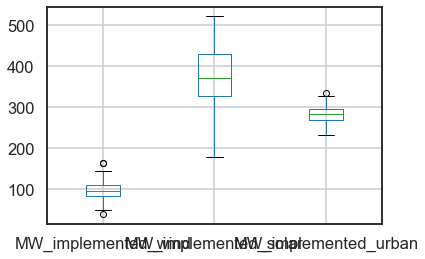

In [121]:
results.loc[6,:].boxplot()